In [1]:
!pip install gym
!pip install gym[atari]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.5 MB/s eta 0:00:00


In [22]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pygame

# Visualization
import matplotlib.pyplot as plt

# Gym Functionalities
from gym import ActionWrapper
from gym.wrappers.monitoring.video_recorder import VideoRecorder

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Create the environment
env_id = "CartPole-v1"
env = gym.make(env_id)

# Set an environment seed for reproducibility
env.reset(seed=42)

# Parameters
max_steps = 20000
lr = 0.005
gamma = 0.9999

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


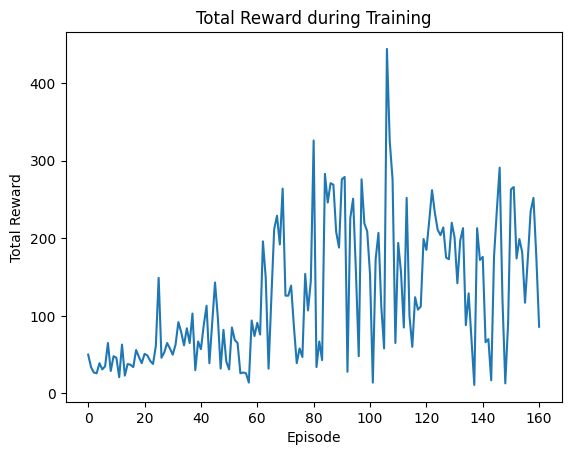

Reward: 232.0
Reward: 208.0
Reward: 124.0
Reward: 132.0
Reward: 206.0


In [24]:


# Neural Network
"""
Our input are (cart position, cart velocity, pole angle, pole angular velocity)
Our action space is (left, right)

"""

"initialize our Policy network"
nn_model = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, env.action_space.n),
    nn.Softmax(dim=-1)
)
optimizer = optim.Adam(nn_model.parameters(), lr=lr)

# Training loop
total_rewards = []
step = 0
""
while step < max_steps:
    obs = torch.tensor(env.reset(), dtype=torch.float32)
    done = False
    actions, states, rewards = [], [], []
    "gather MDP data for one episode"
    while not done:
        probs = nn_model(obs)
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample().item()
        obs_, reward, done, _ = env.step(action)

        actions.append(torch.tensor(action, dtype=torch.int64))
        states.append(obs)
        rewards.append(reward)

        obs = torch.tensor(obs_, dtype=torch.float32)

        step += 1

        if done:
            total_rewards.append(sum(rewards))

    "compute discounted returns"
    discounted_returns = []
    for t in range(len(rewards)):
        G = sum((gamma**k) * r for k, r in enumerate(rewards[t:]))
        discounted_returns.append(G)
    "normalize discounted returns"
    for state, action, G in zip(states, actions, discounted_returns):
        probs = nn_model(state)
        dist = torch.distributions.Categorical(probs=probs)
        log_prob = dist.log_prob(action)

        loss = -log_prob * G

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Plotting rewards
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward during Training')
plt.show()

# Testing loop
for _ in range(5):
    Rewards = []
    obs = torch.tensor(env.reset(), dtype=torch.float32)
    done = False

    while not done:
        probs = nn_model(obs)
        c = torch.distributions.Categorical(probs=probs)
        action = c.sample().item()

        obs_, rew, done, _ = env.step(action)

        obs = torch.tensor(obs_, dtype=torch.float32)

        Rewards.append(rew)

    print(f'Reward: {sum(Rewards)}')

env.close()
